## State space

First, we need to define the Input space $\mathcal{X}$ dimension along with how many categories each feature variable can take.

Given $d$ feature variables $\{X_i\}_{0 \le i \le d-1}$ such that $\forall{i\in \{1, \ldots, d\}}: X_i \in \{0, \ldots, k_i -1 \}$. The state space is of size:
$$|\mathcal{X}| = \prod_{i=0}^{d-1} \left( 1 + k_i\right)$$
Since we want to work in a tabular Reinforcement learning framework (point-wise estimation of the Q function instead of an approximation), we need the state space to be relatively small. That said, we will work with the two following examples:

- $d = 6$; $k_0 = 4, k_1 = 3, k_2 = 3, k_3 = 3, k_4 = 2, k_5 = 4$: $|\mathcal{X}| = 4800$
- $d = 6$; $k_0 = 4, k_1 = 3, k_2 = 4, k_3 = 3, k_4 = 4, k_5 = 4$: $|\mathcal{X}| = 10000$
- $d = 6$; $k_0 = 6, k_1 = 5, k_2 = 6, k_3 = 5, k_4 = 6, k_5 = 6$: $|\mathcal{X}| = 86436$

In each case, feature variables are considered independent and uniform on their respective supports, and a generator will generate data points successively in order to be fed to the RL algorithm.

## Concept

We will work in a binary classification framework and consisder a fairly simple true labeling concept that might give rise to an interesting behaviour of the RL agent. For the first two experiments the concept maps a data point $x = \left(x_0, \ldots, x_{d-1}\right)$ to $1$ if $\forall{i \in \{0, \ldots, d-1\}}: x_i \le 2$, otherwise, it maps it to $0$, for the last experiment the condition is $x_i \le 4$

Given that some feature variables never exceed $2$, an optimal behaviour should completely dismiss these features in its decision making process. We will see if it is the case of our agent in both considered examples.

## Reward

We consider the reward function used in the RLDT paper.

- $R_+ = 5$, the reward of reporting the right label.
- $R_- = -5$, the reward of reporting the wrong label.
- $R_i = -C_i = -1$, the reward of querying the $i^{th}$ feature.

## Algorithm

We use tabular Q-Learning. Here is a brief explanation of the algorithm:

- Initialize the values $\mathcal{Q}\left( s, a\right) = 0$ for all possible state action pairs.
- An episode starts with the environment generating a data point, the agent then receives the empty state.
- At a current state $s_t$ the agent takes an action $a_t$ according to an exploratory policy and receives reward $r_t$ and a next state $s_{t+1}$.
- Compute the temporal difference $\delta_t = r_t + \gamma\textrm{max}_a \mathcal{Q}\left( s_{t+1}, a\right) - \mathcal{Q}\left(s_t, a_t \right)$
- Update: $$\mathcal{Q}\left( s_t, a_t\right) = \mathcal{Q}\left( s_t, a_t\right) + \frac{1}{\textrm{visits}\left(s_t, a_t \right)}\delta_t$$
- Return the greedy policy at the end: $$\pi\left(s \right) = \textrm{argmax}_a \mathcal{Q}\left( s, a\right)$$

An episode ends with the agent taking a report action, so we can actually explore the state-action pairs better if we considered query actions throughout an episode to update their corresponding Q-values and then evaluate the report actions on this path. Formally, let us take only query actions from the empty state until completely observing the data point, and let $\left( s_0, \ldots, s_d\right)$ denote this path in terms of the visited states; then we can update $\mathcal{Q}\left( s_0, a\right), \ldots, \mathcal{Q}\left( s_d, a\right)$ for each report action $a$.

In [1]:
from env import *
from agent import *

## Experiment 1

In [6]:
categories=[4, 3, 3, 3, 2, 4]
labels = [0, 1]

# Feature variables are independent and uniform
generator = dict([(i, np.full(categories[i], 1/categories[i])) for i in range(len(categories))])
    
# Each query action costs -1
rewards_queries = dict([(i, -1) for i in range(len(categories))])

In [7]:
env = Environment(generator=generator, rewards_queries=rewards_queries)
agent = Agent(categories=categories)

Check if the classes are balanced on 10000 generated samples.

In [8]:
l = []
for i in range(10000):
    data_point = env.generate()
    l.append(env.concept(data_point))

print('Fraction of 1 labeled points : %.2f' %(np.sum(l)/10000))

Fraction of 1 labeled points : 0.55


Run Q-Learning on 10000 episodes.

In [9]:
n_episodes = int(1e4)
agent.q_learning(env, n_episodes)

episode : 0


Take the greedy policy.

In [10]:
agent.greedy_policy()

Now, let's test the agent on 10000 new generated points and evaluate its accuracy.

In [11]:
print("accuracy=%.2f" %(agent.test(env, 10000)))

accuracy=1.00


The agent gets a $100\%$ accuracy, however, we can think that it has just seen all possible values of the input variable since the state space is not huge and stored their labels, in which case the solution would be of no interest. So, let's check the actual decisin tree learned by the algorithm and verify if it is minimal regarding our concept in the sense that it uses the fewest amount of features possible.

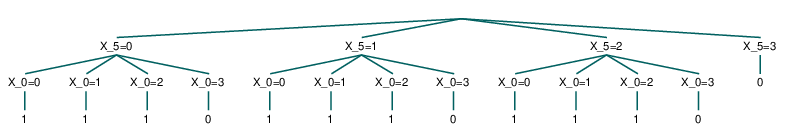

In [12]:
agent.plot_tree()

Only $X_0$ and $X_5$ can have values higher than $2$ and thus are relevant to the decision making process; and indeed we notice that the agent only relied on them and converged to our true concept with as few number of features as possible.

In the next experiment, we will test the agent on a bigger state space ($|\mathcal{X}| = 10000$) and see if it is still successful at retrieving the optimal solution with the fewest number of features possible.

## Experiment 2

In [13]:
categories=[4, 3, 4, 3, 4, 4]
labels = [0, 1]

# Feature variables are independent and uniform
generator = dict([(i, np.full(categories[i], 1/categories[i])) for i in range(len(categories))])
    
# Each query action costs -1
rewards_queries = dict([(i, -1) for i in range(len(categories))])

In [14]:
env = Environment(generator=generator, rewards_queries=rewards_queries)
agent = Agent(categories=categories)

Check if the classes are balanced on 10000 generated samples.

In [15]:
l = []
for i in range(10000):
    data_point = env.generate()
    l.append(env.concept(data_point))

print('Fraction of 1 labeled points : %.2f' %(np.sum(l)/10000))

Fraction of 1 labeled points : 0.31


Run Q-Learning on 300000 episodes.

In [13]:
n_episodes = int(3e5)
agent.q_learning(env, n_episodes)

episode : 0
episode : 10000
episode : 20000
episode : 30000
episode : 40000
episode : 50000
episode : 60000
episode : 70000
episode : 80000
episode : 90000
episode : 100000
episode : 110000
episode : 120000
episode : 130000
episode : 140000
episode : 150000
episode : 160000
episode : 170000
episode : 180000
episode : 190000
episode : 200000
episode : 210000
episode : 220000
episode : 230000
episode : 240000
episode : 250000
episode : 260000
episode : 270000
episode : 280000
episode : 290000


Take the greedy policy.

In [14]:
agent.greedy_policy()

Now, let's test the agent on 10000 new generated points and evaluate its accuracy.

In [15]:
print("accuracy=%.2f" %(agent.test(env, 10000)))

accuracy=1.00


Now,  let's plot the decision tree of our agent. The tree plot is normally unclear, but it becomes clear by double clicking on it.

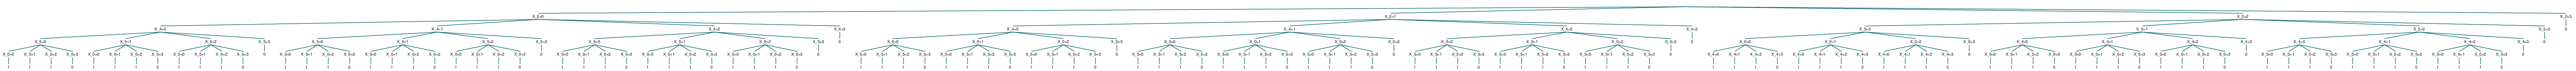

In [16]:
agent.plot_tree()

Indeed we see that the agent only uses feature variables $X_0, X_2, X_4, X_5$, the only features that can have values higher than $2$. The algorithm converged to the optimal minimal tree.

## Experiment 3

In [2]:
categories = [6, 5, 6, 5, 6, 6]
labels = [0, 1]

# Feature variables are independent and uniform
generator = dict([(i, np.full(categories[i], 1/categories[i])) for i in range(len(categories))])
    
# Each query action costs -1
rewards_queries = dict([(i, -1) for i in range(len(categories))])

In [3]:
env = Environment(generator=generator, rewards_queries=rewards_queries, split=5)
agent = Agent(categories=categories)

Check if the classes are balanced on 10000 generated samples.

In [4]:
l = []
for i in range(10000):
    data_point = env.generate()
    l.append(env.concept(data_point))

print('Fraction of 1 labeled points : %.2f' %(np.sum(l)/10000))

Fraction of 1 labeled points : 0.48


Run Q-Learning on 5000000 episodes. It takes a longer time here.

In [5]:
n_episodes = int(5e6)
agent.q_learning(env, n_episodes)

episode : 0
episode : 10000
episode : 20000
episode : 30000
episode : 40000
episode : 50000
episode : 60000
episode : 70000
episode : 80000
episode : 90000
episode : 100000
episode : 110000
episode : 120000
episode : 130000
episode : 140000
episode : 150000
episode : 160000
episode : 170000
episode : 180000
episode : 190000
episode : 200000
episode : 210000
episode : 220000
episode : 230000
episode : 240000
episode : 250000
episode : 260000
episode : 270000
episode : 280000
episode : 290000
episode : 300000
episode : 310000
episode : 320000
episode : 330000
episode : 340000
episode : 350000
episode : 360000
episode : 370000
episode : 380000
episode : 390000
episode : 400000
episode : 410000
episode : 420000
episode : 430000
episode : 440000
episode : 450000
episode : 460000
episode : 470000
episode : 480000
episode : 490000
episode : 500000
episode : 510000
episode : 520000
episode : 530000
episode : 540000
episode : 550000
episode : 560000
episode : 570000
episode : 580000
episode : 5

In [6]:
agent.greedy_policy()

We did not converge perfectly to the true concept in this experiment, but we still have $99\%$ accuracy on $10000$ generated samples. Maybe the algorithm needs much more time in this experiment due to the huge state space and the fact that Q-Learning needs to visit all state-action pairs enough times.

In [7]:
print("accuracy=%.2f" %(agent.test(env, 10000)))

accuracy=0.99


If we look closely, we can see below that the algorithm uses only the relevant features to our concept and gets almost all the tree branches correct, except for $X_0=0 \rightarrow X_2=2 \rightarrow X_4=1$ where it should have splitted further with respect to $X_5$. So maybe the algorithm needed to explore more the states where $X_0=0, X_2=2, X_4=1$. One thing to bear in mind is that we used a purely exploratory policy in Q-Learning, a better suited exploration strategy might have been to use an $\epsilon-$greedy policy.

The tree plot is normally unclear, but it becomes clear by double clicking on it.

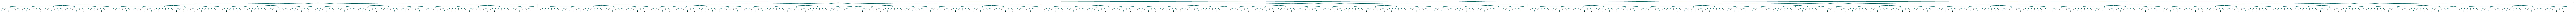

In [8]:
agent.plot_tree()

# Double DQN

Now we consider huge state spaces where Q-Learning is not feasible and approximations are needed. Consider the following setting:

- $d = 15$; $k_0 = 3, k_1 = 5, k_2 = 3, k_3 = 3, k_4 = 3, k_5 = 5, k_6 = 3, \\ k_7 = 5, k_8 = 3, k_9 = 3, k_{10} = 4, k_{11} = 3, k_{12} = 3, k_{13} = 3, k_{14} = 5$: $|\mathcal{X}| = 147622500$


We label data points with all feature values lower than or equal to $8$ as $1$, and $0$ if there exists a feature with value higher than $8$.

We train an architecture of two $32-$fully connected layers with ReLU activation function and an fully-connected output layer with number of units equal to the number of possible actions, which means here: $17$. We use a relatively high learning rate of $10^{-3}$ since we noticed the loss to be very stable during training.

In [2]:
categories = [3, 5, 3, 3, 3, 5, 3, 5, 3, 3, 4, 3, 3, 3, 5]
d = len(categories)
labels = [0, 1]
actions = range(d + len(labels))

# Feature variables are independent and uniform
generator = dict([(i, np.full(categories[i], 1/categories[i])) for i in range(len(categories))])

# Each query action costs -1
rewards_queries = dict([(i, -1) for i in range(len(categories))])

# Define the one-hot encoder.
encoder = Encoder(categories=categories)

In [3]:
env = EnvironmentDQN(generator, rewards_queries, encoder, r_plus=5, r_minus=-5, split=4)
agent = AgentDQN(categories=categories)

Check if the classes are balanced on 10000 generated samples.

In [4]:
l = []
for i in range(10000):
    data_point = env.generate()
    l.append(env.concept(data_point))

print('Fraction of 1 labeled points : %.5f' %(np.sum(l)/10000))

Fraction of 1 labeled points : 0.41510


Run training for 20000 episodes, you can check the evolution of the loss with command ``tensorboard --logdir runs/``. If it becomes constant for many episodes, one can assume that the gradient has hit a plateau and can thus stop training, the progress will not be lost, agent.q_network holds the current network parameters.

In [ ]:
agent.train(env, n_train=20000, n_pretrain=512, n_learn=5, max_tau=50, decay_rate=1e-5, lr=1e-3, batch_size=256)

Save the models' weights.

In [ ]:
agent.save_weights('weights.pth')

Load the models' weights.

In [5]:
agent.load_weights('ddqn_weights.pth')

Now, let's test the agent on 10000 new generated points and evaluate its accuracy.

In [6]:
agent.test(env, 10000)

0.9757

We have $97\%$ accuracy, which is very good in this setting with huge state space. Now it would be interesting to visualize our agent's policy as a decision tree, we know that only feature variables $X_1, X_5, X_7, X_{14}$ are relevant to the decision process, so it is interesting to see if the agent actually understood this information.

The tree plot is normally unclear, but it becomes clear by double clicking on it.

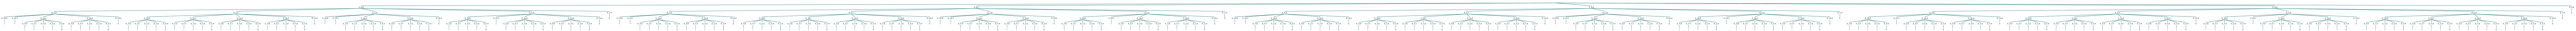

In [8]:
agent.plot_tree(encoder)

Indeed the agent only considers feature variables $X_1, X_5, X_7, X_{14}$ in its decision tree, furthermore, it is very close to the true optimal decision tree, we notice that while most of the branches completed their growth to coincide with the optial ones, some did not, and it is likely due to an insufficient exploration of these states. A uniform sampling over the replay buffer is not really an ideal way of sampling since we cannot emphasize with it the use of some "meaningful" transitions in the gradient estimations. With Prioritized Experience Replay, maybe the branches that did not complete their growth here would have seen their corresponding states sampled more and more until the agent learns eventually to complete them.